# Bonsai Demo

## Imports

In [1]:
import os
import sys

import numpy as np
import pandas as pd
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

note_dir = os.getcwd()
root_dir = os.path.dirname(note_dir)
sys.path.append(root_dir)

import bonsai
from bonsai.base import *

In [2]:
def plot_corr(corr):
    fig = plt.figure(figsize=((10,10))) # slightly larger
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='seismic')
    fig.colorbar(cax)
    
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.4f}'.format(z), ha='center', va='center', color='w')
    return 

In [3]:
def summarize_dataset(df, samples=1000, random_state=997, replace=False):
    """
    This function plots a grid of plots that give some insights into pairwise relationships between
    the attributes in the dataset.
    
    Explicit correlations or special distributions should be very visible here.
    """
    
    df_subsample = df.sample(n=samples, replace=False, random_state=random_state)
    
    sns.set(style="ticks", color_codes=True)
    g = sns.PairGrid(df_subsample) # slice every 10 otherwise a bit slow
    g = g.map_diag(plt.hist) # histograms on the diagonal
    g = g.map_lower(sns.kdeplot, cmap="Blues_d") # density plot on the lower plots
    g = g.map_upper(plt.scatter) # scatter plots on the upper plots
    return

## Demo

### Dataset

In [4]:
# Pre-built regression tree using Bonsai
X, y = make_friedman1(n_samples=10**5, noise=2) 
n, m = X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Inspection 1: Correlation Matrix

In [5]:
df = pd.DataFrame(X)
df = df.assign(y=y)
df.head()

,0,1,2,3,4,5,6,7,8,9,y
0,0.303674,0.232574,0.222086,0.755810,0.641762,0.163856,0.828582,0.725323,0.521086,0.099640,14.081439
1,0.462626,0.613106,0.317487,0.752821,0.205176,0.124792,0.910077,0.293291,0.720603,0.034141,16.630243
2,0.534466,0.514670,0.039164,0.030628,0.267920,0.669518,0.124174,0.948692,0.530768,0.200892,10.250312
3,0.325268,0.251495,0.474328,0.319717,0.908101,0.780298,0.699665,0.616676,0.416437,0.594022,10.027411
4,0.074329,0.125653,0.686095,0.123861,0.112834,0.604559,0.161273,0.492917,0.043804,0.950483,1.082570


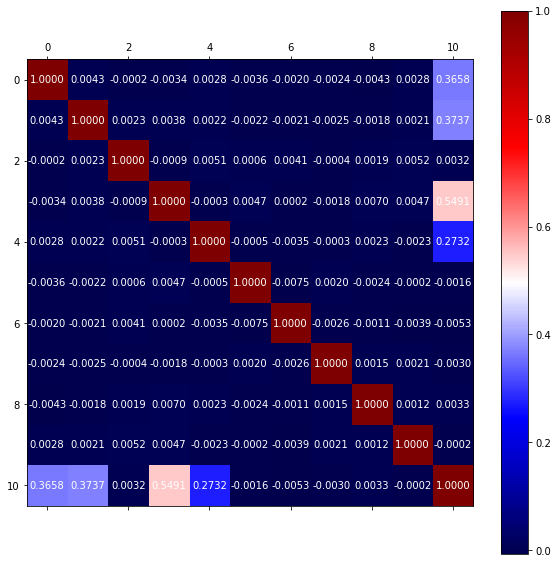

In [6]:
corr = df.corr().values
plot_corr(corr)

In [7]:
# Pandas-direct way
df_corr = pd.DataFrame(corr)
df_corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2) # 'coolwarm' & 'RdBu_r' &'BrBG' 

,0,1,2,3,4,5,6,7,8,9,10
0,1,0.0043,-0.0002,-0.0034,0.0028,-0.0036,-0.002,-0.0024,-0.0043,0.0028,0.37
1,0.0043,1,0.0023,0.0038,0.0022,-0.0022,-0.0021,-0.0025,-0.0018,0.0021,0.37
2,-0.0002,0.0023,1,-0.0009,0.0051,0.00055,0.0041,-0.00044,0.0019,0.0052,0.0032
3,-0.0034,0.0038,-0.0009,1,-0.0003,0.0047,0.00025,-0.0018,0.007,0.0047,0.55
4,0.0028,0.0022,0.0051,-0.0003,1,-0.00045,-0.0035,-0.00026,0.0023,-0.0023,0.27
5,-0.0036,-0.0022,0.00055,0.0047,-0.00045,1,-0.0075,0.002,-0.0024,-0.00021,-0.0016
6,-0.002,-0.0021,0.0041,0.00025,-0.0035,-0.0075,1,-0.0026,-0.0011,-0.0039,-0.0053
7,-0.0024,-0.0025,-0.00044,-0.0018,-0.00026,0.002,-0.0026,1,0.0015,0.0021,-0.003
8,-0.0043,-0.0018,0.0019,0.007,0.0023,-0.0024,-0.0011,0.0015,1,0.0012,0.0033
9,0.0028,0.0021,0.0052,0.0047,-0.0023,-0.00021,-0.0039,0.0021,0.0012,1,-0.00018


### Inspection 2: Seaborn Summary

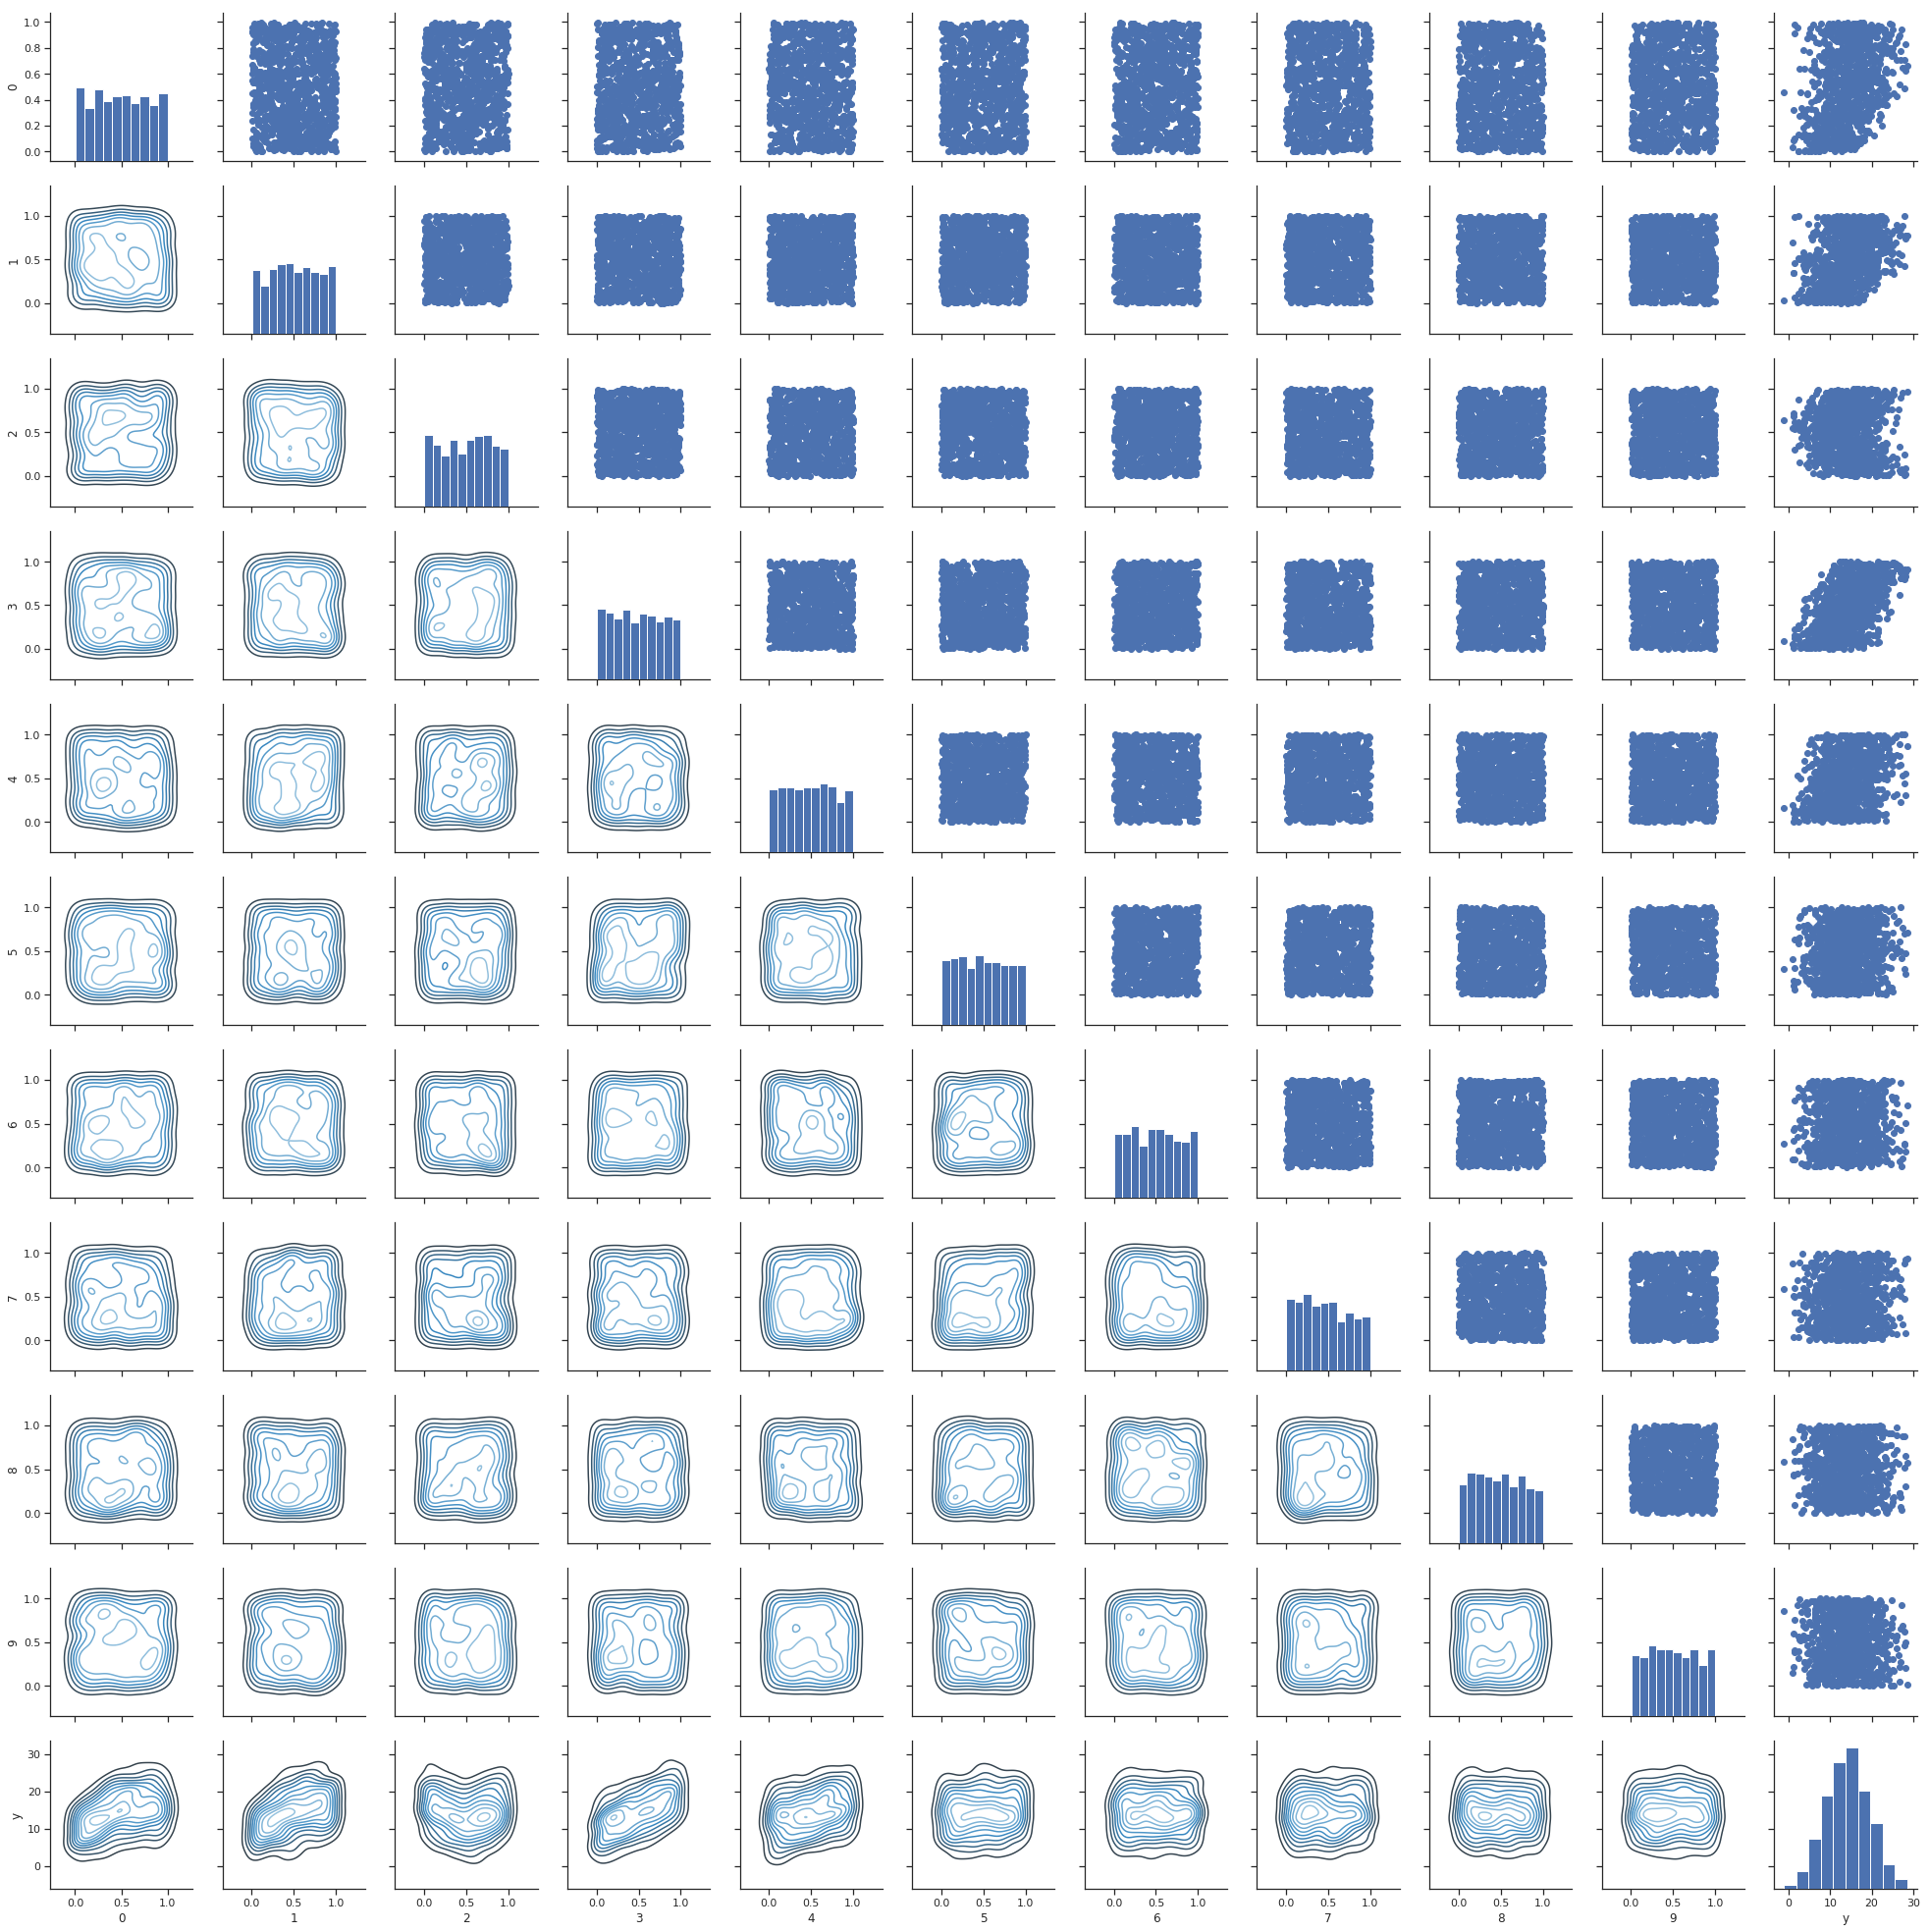

In [8]:
summarize_dataset(df, samples=1000)

## Learn Tree

In [9]:
# Initialize
model = C45Tree(max_depth=2)

# Fit
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

rmse = np.sqrt(np.mean((y_test - y_pred)**2))
rmse

5.228162974490687

In [10]:
idxs = model.predict(X_test, output_type="index")
len(idxs)

20000

In [11]:
leaves_array = model.dump()

for leaf in leaves_array:
    n_samples = leaf['n_samples']
    val = leaf['y']
    
    msg = """
    n_samples in the leaf:  {}
    value:                  {}
    """.format(n_samples, val)
    print(msg)


    n_samples in the leaf:  50359.0
    value:                  14.416860947773811
    

    n_samples in the leaf:  2508.0
    value:                  14.506425817081265
    

    n_samples in the leaf:  13593.0
    value:                  13.231101886296313
    

    n_samples in the leaf:  13540.0
    value:                  15.69525229520081
    


In [12]:
model.dump()

[{'eqs': [{'svar': 8,
    'sval': 0.6601432173212981,
    'sidx': 2208,
    'op': '<',
    'missing': 1},
   {'svar': 7,
    'sval': 0.9531211780321872,
    'sidx': 2028,
    'op': '<',
    'missing': 1}],
  'i_start': 0,
  'i_end': 50359,
  '_id': 'ROOT::2208L::2028L',
  'n_samples': 50359.0,
  'y': 14.416860947773811,
  'depth': 2,
  'y_lst': [14.421109887419114, 14.416860947773811],
  'is_leaf': True,
  'index': 0},
 {'eqs': [{'svar': 8,
    'sval': 0.6601432173212981,
    'sidx': 2208,
    'op': '<',
    'missing': 1},
   {'svar': 7,
    'sval': 0.9531211780321872,
    'sidx': 2028,
    'op': '>=',
    'missing': 0}],
  'i_start': 50359,
  'i_end': 52867,
  '_id': 'ROOT::2208L::2028R',
  'n_samples': 2508.0,
  'y': 14.506425817081265,
  'depth': 2,
  'y_lst': [14.421109887419114, 14.506425817081265],
  'is_leaf': True,
  'index': 1},
 {'eqs': [{'svar': 8,
    'sval': 0.6601432173212981,
    'sidx': 2208,
    'op': '>=',
    'missing': 0},
   {'svar': 4,
    'sval': 0.49999910595155

In [13]:
tree_ind = model.tree_ind
tree_val = model.tree_val

tree_ind

array([[-1,  8,  0,  1,  2, -1],
       [-1,  7,  0,  3,  4, -1],
       [-1,  4,  0,  5,  6, -1],
       [ 1, -1, -1, -1, -1,  0],
       [ 1, -1, -1, -1, -1,  1],
       [ 1, -1, -1, -1, -1,  2],
       [ 1, -1, -1, -1, -1,  3]])

In [14]:
tree_val

array([[ 0.66014322, -1.        ],
       [ 0.95312118, -1.        ],
       [ 0.49999911, -1.        ],
       [-1.        , 14.41686095],
       [-1.        , 14.50642582],
       [-1.        , 13.23110189],
       [-1.        , 15.6952523 ]])

In [15]:
model.get_counts()

array([[80000, 52867, 27133],
       [52867, 50359,  2508],
       [27133, 13593, 13540],
       [50359,    -1,    -1],
       [ 2508,    -1,    -1],
       [13593,    -1,    -1],
       [13540,    -1,    -1]])

In [16]:
model.counts

array([[80000, 52867, 27133],
       [52867, 50359,  2508],
       [27133, 13593, 13540],
       [50359,    -1,    -1],
       [ 2508,    -1,    -1],
       [13593,    -1,    -1],
       [13540,    -1,    -1]])

In [17]:
model.get_ratios()

array([[ 0.6608375 ,  0.3391625 ],
       [ 0.9525602 ,  0.0474398 ],
       [ 0.50097667,  0.49902333],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ]])

In [18]:
model.ratios

array([[ 0.6608375 ,  0.3391625 ],
       [ 0.9525602 ,  0.0474398 ],
       [ 0.50097667,  0.49902333],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ]])

In [19]:
old_tree = model

In [20]:
new_tree = model.randomize_tree()
msg = """
old tree counts:
{}
new tree counts:
{}
old tree ratios:
{}
new tree ratios:
{}
""".format(old_tree.get_counts(), new_tree.get_counts(), old_tree.get_ratios(), new_tree.get_ratios())
print(msg)


old tree counts:
[[80000 52867 27133]
 [52867 50359  2508]
 [27133 13593 13540]
 [50359    -1    -1]
 [ 2508    -1    -1]
 [13593    -1    -1]
 [13540    -1    -1]]
new tree counts:
[[80000 27133 52867]
 [52867 50359  2508]
 [27133 13540 13593]
 [50359    -1    -1]
 [ 2508    -1    -1]
 [13593    -1    -1]
 [13540    -1    -1]]
old tree ratios:
[[ 0.6608375   0.3391625 ]
 [ 0.9525602   0.0474398 ]
 [ 0.50097667  0.49902333]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]]
new tree ratios:
[[ 0.3391625   0.6608375 ]
 [ 0.9525602   0.0474398 ]
 [ 0.49902333  0.50097667]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]
 [-1.         -1.        ]]



In [21]:
new_tree.get_counts(), new_tree.get_ratios()

(array([[80000, 27133, 52867],
        [52867, 50359,  2508],
        [27133, 13540, 13593],
        [50359,    -1,    -1],
        [ 2508,    -1,    -1],
        [13593,    -1,    -1],
        [13540,    -1,    -1]]), array([[ 0.3391625 ,  0.6608375 ],
        [ 0.9525602 ,  0.0474398 ],
        [ 0.49902333,  0.50097667],
        [-1.        , -1.        ],
        [-1.        , -1.        ],
        [-1.        , -1.        ],
        [-1.        , -1.        ]]))

In [22]:
import copy

In [23]:
model2 = copy.copy(model)

In [24]:
model3 = copy.deepcopy(model)

In [25]:
model2.tree_ind

array([[-1,  8,  0,  1,  2, -1],
       [-1,  7,  0,  3,  4, -1],
       [-1,  4,  0,  5,  6, -1],
       [ 1, -1, -1, -1, -1,  0],
       [ 1, -1, -1, -1, -1,  1],
       [ 1, -1, -1, -1, -1,  2],
       [ 1, -1, -1, -1, -1,  3]])

In [26]:
model.tree_ind[0,0]=99

In [27]:
model.tree_ind

array([[99,  8,  0,  1,  2, -1],
       [-1,  7,  0,  3,  4, -1],
       [-1,  4,  0,  5,  6, -1],
       [ 1, -1, -1, -1, -1,  0],
       [ 1, -1, -1, -1, -1,  1],
       [ 1, -1, -1, -1, -1,  2],
       [ 1, -1, -1, -1, -1,  3]])

In [28]:
model2.tree_ind

array([[99,  8,  0,  1,  2, -1],
       [-1,  7,  0,  3,  4, -1],
       [-1,  4,  0,  5,  6, -1],
       [ 1, -1, -1, -1, -1,  0],
       [ 1, -1, -1, -1, -1,  1],
       [ 1, -1, -1, -1, -1,  2],
       [ 1, -1, -1, -1, -1,  3]])

In [29]:
model3.tree_ind

array([[-1,  8,  0,  1,  2, -1],
       [-1,  7,  0,  3,  4, -1],
       [-1,  4,  0,  5,  6, -1],
       [ 1, -1, -1, -1, -1,  0],
       [ 1, -1, -1, -1, -1,  1],
       [ 1, -1, -1, -1, -1,  2],
       [ 1, -1, -1, -1, -1,  3]])

## Count per Node

I need to know how many instances pass a node.

In [30]:
def count_samples(tree, node_idx):
    """
    Count samples for specific node in the tree.
    """
    
    tree_ind = tree.tree_ind
    tree_val = tree.tree_val
    leaves = tree.leaves
    
    def is_leaf(node_idx):
        return tree_ind[node_idx][0] == 1
    
    if is_leaf(node_idx):
        leaf_idx = tree_ind[node_idx][5]
        leaf = leaves[leaf_idx]
        return leaf['n_samples']
        
    else:
        l_idx = tree_ind[node_idx][3]
        r_idx = tree_ind[node_idx][4]
        return count_samples(tree, l_idx) + count_samples(tree, r_idx)

In [31]:
count_samples(model, 1) + count_samples(model, 2)

80000.0

In [32]:
n_samples = [count_samples(model, node_idx) for node_idx in range(len(model.tree_ind))]
n_samples

[80000.0, 52867.0, 27133.0, 50359.0, 2508.0, 13593.0, 13540.0]

## Generate DataStructure that we need

For our first, basic idea.

In [33]:
def adapt_tree_information(tree):
    tree_ind = tree.tree_ind
    tree_val = tree.tree_val
    leaves = tree.leaves
    
    n_nodes, _ = tree_ind.shape
    
    adapt_tree_int_header = ('l_idx', 'r_idx', 'l_samples', 'r_samples', 'svar')
    adapt_tree_flt_header = ('sval', 'l_ratio', 'r_ratio')
    
    adapt_tree_int = np.zeros((n_nodes, len(adapt_tree_int_header)), dtype=int)
    adapt_tree_flt = np.zeros((n_nodes, len(adapt_tree_flt_header)), dtype=float)
    
    def is_leaf(node_idx):
        return tree_ind[node_idx][0] == 1
    
    for n in range(n_nodes):
        leaf = is_leaf(n)
        
        adapt_tree_int[n, 0] = tree_ind[n][3]                               # l_idx
        adapt_tree_int[n, 1] = tree_ind[n][4]                               # r_idx
        adapt_tree_int[n, 2] = count_samples(tree, tree_ind[n][3]) if not leaf else -1 # l_samples
        adapt_tree_int[n, 3] = count_samples(tree, tree_ind[n][4]) if not leaf else -1 # r_samples
        adapt_tree_int[n, 4] = tree_ind[n][1]                               # svar
        
        adapt_tree_flt[n, 0] = tree_val[n][0]                               # sval
        
        n_samples = adapt_tree_int[n, 2] + adapt_tree_int[n, 3]
        adapt_tree_flt[n, 1] = adapt_tree_int[n, 2]/n_samples if not leaf else  -1           # l_ratio
        adapt_tree_flt[n, 2] = adapt_tree_int[n, 3]/n_samples if not leaf else  -1            # r_ratio
    
    return adapt_tree_int, adapt_tree_flt

In [34]:
def tunnel(node_ind, direction=0):
    l_child_idx = node_ind[3] # Left child index
    r_child_idx = node_ind[4] # Right child index
    
    if direction==0:
        node_ind[3] = r_child_idx
    elif direction==1:
        node_ind[4] = l_child_idx
    elif direction==-1:
        node_ind[3] = r_child_idx
        node_ind[4] = l_child_idx
    else:
        msg = """
        Tunneling direction is either:
             0     left to right,
             1     right to left
             -1    swap 
        Did not recognize direction: {}
        """.format(direction)
        raise ValueError(msg)
    
    return node_ind

In [35]:
def swap(node_ind):
    return tunnel(node_ind, direction=-1)

In [36]:
def must_swap(l_ratio, s):
    """
    l_ratio is the ratio of samples sent to the left child.
    
    s is a sample drawn from a random distribution.
    """
    
    d = 0.5-l_ratio
    
    return abs(s) > abs(d)

In [37]:
swap_node([-1,2,5,10,20,50])

NameError: name 'swap_node' is not defined

In [ ]:
adapt_tree_information(model)

In [ ]:
a = [1,2,3]
b = a
b[2] = 'x'

In [ ]:
a

In [ ]:
def randomize_tree(tree):
    tree_ind = tree.tree_ind
    tree_val = tree.tree_val
    leaves = tree.leaves
    
    n_nodes, _ = tree_ind.shape
    
    sigma = 0.1
    mu = 0.5
    random_samples = np.random.normal(mu, sigma, n_nodes)
    random_samples = np.round(random_samples, decimals=0)
    
    for n in range(n_nodes):
        l_idx = tree_ind[n][3]
        r_idx = tree_ind[n][4]
        
        d = 50-l_ratio
        s = random_samples[n]
        must_swap = abs(s) > abs(d)
        
        if must_swap:
            tree_ind[n][3] = r_idx
            tree_ind[n][4] = l_idx   
            
    tree.tree_ind = tree_ind
    tree.tree_ind = tree_ind
    
    return

In [ ]:
sigma = 10
mu = 0
s = np.random.normal(mu, sigma, 1000)
s = np.round(s, decimals=0)
s[:10]

In [ ]:
abs(-2)

In [ ]:
def normal_dist(x, mu=0.5, sigma=0.1):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

In [ ]:
normal_dist(0.5)

In [ ]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()